In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [5]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"

In [2]:
patient_pred_df = pd.read_csv('/root/autodl-tmp/df_patient_pred_7945.csv')
patient_pred_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,0.278118,0.010000,0.010000,0.010000,0.010000,0.278118,0.017289,0.010000
1,1.2.826.0.1.3680043.10005,0.909179,0.081606,0.023729,0.036615,0.023952,0.112395,0.909179,0.263013
2,1.2.826.0.1.3680043.10014,0.939372,0.010000,0.010000,0.010000,0.875186,0.939372,0.014286,0.010000
3,1.2.826.0.1.3680043.10016,0.553299,0.390643,0.062880,0.010000,0.010000,0.011736,0.042251,0.553299
4,1.2.826.0.1.3680043.10032,0.398646,0.280756,0.042777,0.010000,0.010000,0.366854,0.039860,0.398646


In [10]:
patient_pred_df = pd.read_csv('/root/autodl-tmp/df_patient_pred_7945.csv',header = 0, names=['StudyInstanceUID'] + [f'P{i}' for i in range(8)]).set_index('StudyInstanceUID')
label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
# patient_pred_df.rename(columns = {"patient_overall" : "UID"}, inplace = True)

label_df.rename(columns = {"patient_overall" : "C0"}, inplace = True)
patient_pred_df = pd.concat((patient_pred_df, label_df), axis=1)
patient_pred_df = patient_pred_df[~pd.isna(patient_pred_df['P0'])]
patient_pred_df

,P0,P1,P2,P3,P4,P5,P6,P7,C0,C1,C2,C3,C4,C5,C6,C7
StudyInstanceUID,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,0.278118,0.010000,0.010000,0.010000,0.010000,0.278118,0.017289,0.010000,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10005,0.909179,0.081606,0.023729,0.036615,0.023952,0.112395,0.909179,0.263013,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10014,0.939372,0.010000,0.010000,0.010000,0.875186,0.939372,0.014286,0.010000,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.10016,0.553299,0.390643,0.062880,0.010000,0.010000,0.011736,0.042251,0.553299,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.10032,0.398646,0.280756,0.042777,0.010000,0.010000,0.366854,0.039860,0.398646,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.2.826.0.1.3680043.9926,0.970281,0.060058,0.970281,0.023002,0.153391,0.010000,0.010000,0.037288,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.9940,0.983754,0.078408,0.010000,0.010000,0.983754,0.047393,0.022133,0.021968,1,0,0,0,1,1,0,0
1.2.826.0.1.3680043.9994,0.716848,0.264340,0.023959,0.105284,0.010000,0.010000,0.032347,0.716848,0,0,0,0,0,0,0,0


In [9]:
def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()

In [14]:
prob = patient_pred_df[[f'P{i}' for i in range(8)]].values
label = patient_pred_df[[f'C{i}' for i in range(8)]].values

In [24]:
loss = cal_loss(prob, label)
print('baseline:', loss)

baseline: 0.4341312172728348


min loss: 0.4213881542385558


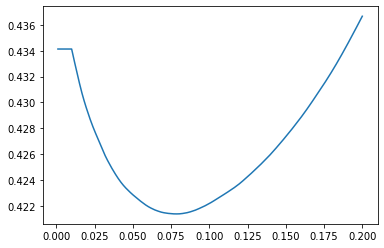

In [25]:
# only clip lower bound
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=clip, a_max=1)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

min loss: 0.4341312172728348


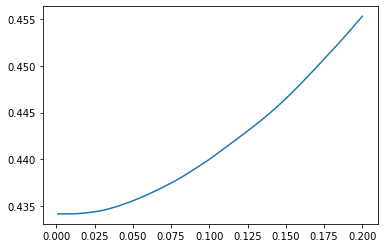

In [26]:
# clip upper
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=0, a_max=1-clip)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

min loss: 0.4240638965809748


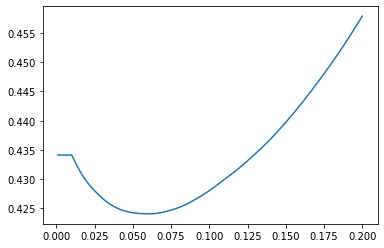

In [27]:
# clip both
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=clip, a_max=1-clip)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)